# Подготовка датасета

нужно сначала подготовить папку датасет, в которой будет папка с данными, и папка с масками, чтобы они совпадали.

для этого берем название картинки, убираем расширение, и ищем в списке файлов с масками файл с названием:

'mask' + file_name + '.jpg'

Найденный файл и является целевым выводом.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
import os

In [86]:
"""
датасет лежит в папке на диске, в ту же папку загрузим csv,
после подключения к диску, нужно обновить ссылку на папку с данными
"""
path_to_dir = '/content/drive/MyDrive/Colab Notebooks/RuslanSegmentation'

"""
все данные лежать внутри основной директории в папке `dataset`

поэтому пути до картинок и масок пропишем так:
"""
samples_dir = path_to_dir + '/dataset/image/'
masks_dir = path_to_dir + '/dataset/mask/'

# получаем список картинок
samples = os.listdir(samples_dir)
# получаем список масок
masks = os.listdir(masks_dir)

print(f'images amount: {len(samples)}\nmasks amount: {len(masks)}')

images amount: 556
masks amount: 556


In [87]:
"""
теперь нам нужно создать пары `image:mask`
для этого пробежимся по всем картинкам и
найдем соответствующую маску для каждой картинки
следующим образом:
    1. берем названием картинки, например: `r3d1_0193.dcm.jpg`
    2. разрезаем строку по символу '.' и берем только имя `r3d1_0193`
    3. находим маску с таким же именем
"""
_samples, _labels = [], []
for item in samples: # бежим по всем элемнетам
    name = item.split('.')[0] # разрезаем сроку и берем первый элемент
    _samples.append('image/' + item)
    _labels.append('mask/' + masks[masks.index('mask ' + name + '.jpg.jpg')])

print(_samples[0:3], _labels[0:3])
masks = _labels
samples = _samples

['image/r3d1_0111.dcm.jpg', 'image/r3d1_0131.dcm.jpg', 'image/r3d1_0277.dcm.jpg'] ['mask/mask r3d1_0111.jpg.jpg', 'mask/mask r3d1_0131.jpg.jpg', 'mask/mask r3d1_0277.jpg.jpg']


In [88]:
# Создаем CSV для обучения

import pandas as pd

df = pd.DataFrame({'image': samples, 'mask': masks})
df.head()

,image,mask
0,image/r3d1_0111.dcm.jpg,mask/mask r3d1_0111.jpg.jpg
1,image/r3d1_0131.dcm.jpg,mask/mask r3d1_0131.jpg.jpg
2,image/r3d1_0277.dcm.jpg,mask/mask r3d1_0277.jpg.jpg
3,image/r3d1_0155.dcm.jpg,mask/mask r3d1_0155.jpg.jpg
4,image/r3d1_0151.dcm.jpg,mask/mask r3d1_0151.jpg.jpg


In [89]:
# сохраняем наш csv в нашу директорию
df.to_csv(path_to_dir + '/data.csv', index=0)

Реализация архитектуры UNet

In [144]:
import os
import math
import random
from PIL import Image

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data.dataset import Subset
from torch._utils import _accumulate
# from . import config
from torch.nn import ConvTranspose2d
from torch.nn import Conv2d
from torch.nn import MaxPool2d
from torch.nn import Module
from torch.nn import ModuleList
from torch.nn import ReLU
from torch.nn import functional as F
from torch import default_generator, randperm

from torchvision.transforms import CenterCrop
from torchvision.io import read_image
from torchvision import transforms


batch_size = 16
lr = 1e-3
momentum = 0.9

создаем датасет

In [118]:
class SegmentationDataset(Dataset):
	""" Segmentation Dataset"""
	def __init__(self, root_dir, csv_file=None, image_csv=None, transforms=None):
		# получаем датафрейм
		if image_csv is not None:
			seg_csv = image_csv
		else:
			seg_csv = pd.read_csv(csv_file)
		# записываем названия файлов изображений и масок
		self.image_names = seg_csv['image'].values
		self.mask_names = seg_csv['mask'].values

		# запомним корневую папку
		self.root_dir = root_dir
		self.transforms = transforms

	def __len__(self):
		# return the number of total samples contained in the dataset
		return len(self.image_names)

	def __getitem__(self, idx):
		# grab the image path from the current index
		imagePath = self.root_dir + '/dataset/' + self.image_names[idx]
		maskPath = self.root_dir + '/dataset/' + self.mask_names[idx]

		image = Image.open(imagePath)
		image = transforms.functional.rgb_to_grayscale(image, 1)
		mask = Image.open(maskPath)
		mask = transforms.functional.rgb_to_grayscale(mask, 1)

		# check to see if we are applying any transformations
		if self.transforms is not None:
			# apply the transformations to both image and its mask
			image = self.transforms(image)
			mask = self.transforms(mask)

		# return a tuple of the image and its mask
		return (image, mask)

In [119]:
def random_split(dataset, lengths,
                 generator=default_generator):
    r"""
    Randomly split a dataset into non-overlapping new datasets of given lengths.

    If a list of fractions that sum up to 1 is given,
    the lengths will be computed automatically as
    floor(frac * len(dataset)) for each fraction provided.

    After computing the lengths, if there are any remainders, 1 count will be
    distributed in round-robin fashion to the lengths
    until there are no remainders left.

    Optionally fix the generator for reproducible results, e.g.:

    >>> random_split(range(10), [3, 7], generator=torch.Generator().manual_seed(42))
    >>> random_split(range(30), [0.3, 0.3, 0.4], generator=torch.Generator(
    ...   ).manual_seed(42))

    Args:
        dataset (Dataset): Dataset to be split
        lengths (sequence): lengths or fractions of splits to be produced
        generator (Generator): Generator used for the random permutation.
    """
    if math.isclose(sum(lengths), 1) and sum(lengths) <= 1:
        subset_lengths: List[int] = []
        for i, frac in enumerate(lengths):
            if frac < 0 or frac > 1:
                raise ValueError(f"Fraction at index {i} is not between 0 and 1")
            n_items_in_split = int(
                math.floor(len(dataset) * frac)  # type: ignore[arg-type]
            )
            subset_lengths.append(n_items_in_split)
        remainder = len(dataset) - sum(subset_lengths)  # type: ignore[arg-type]
        # add 1 to all the lengths in round-robin fashion until the remainder is 0
        for i in range(remainder):
            idx_to_add_at = i % len(subset_lengths)
            subset_lengths[idx_to_add_at] += 1
        lengths = subset_lengths
        for i, length in enumerate(lengths):
            if length == 0:
                warnings.warn(f"Length of split at index {i} is 0. "
                              f"This might result in an empty dataset.")

    # Cannot verify that dataset is Sized
    if sum(lengths) != len(dataset):    # type: ignore[arg-type]
        raise ValueError("Sum of input lengths does not equal the length of the input dataset!")

    indices = randperm(sum(lengths), generator=generator).tolist()  # type: ignore[call-overload]
    return [Subset(dataset, indices[offset - length : offset]) for offset, length in zip(_accumulate(lengths), lengths)]

In [155]:
# проверяй, чтобы совпадало
root_path = '/content/drive/MyDrive/Colab Notebooks/RuslanSegmentation'
csv_path = root_path + '/' + 'data.csv'

dataset = SegmentationDataset(root_dir=root_path,
                              csv_file=csv_path,
                              transforms=transforms.Compose([
                                transforms.Resize((256, 256)),
                                transforms.ToTensor(),
                                # Use mean and std for pretrained models
                                # https://pytorch.org/docs/stable/torchvision/models.html
                                transforms.Normalize(mean=[0.406], std=[0.225])
                                ]))
len(dataset)

556

In [156]:
train_set, valid_set = random_split(dataset, [0.8, 0.2], generator=torch.Generator().manual_seed(42))

print(f'train set size: {len(train_set)}\nvalidation set size: {len(valid_set)}')

train set size: 445
validation set size: 111


In [157]:
train_dataloader = torch.utils.data.DataLoader(
  train_set,
  batch_size=batch_size,
  shuffle=True,
  drop_last=True)

valid_dataloader = torch.utils.data.DataLoader(
  valid_set,
  batch_size=batch_size,
  drop_last=True,
  shuffle=True)

In [158]:
idx = np.random.randint(len(valid_set))
data, label = valid_set[idx]
print("Training Dataset length: {}".format(len(train_set)))
print("Validation Dataset length: {}".format(len(valid_set)))
print("Data shape: {}".format(data.shape))
print("Label: {}".format(label))

Training Dataset length: 445
Validation Dataset length: 111
Data shape: torch.Size([1, 256, 256])
Label: tensor([[[-1.8044, -1.8044, -1.8044,  ..., -1.8044, -1.8044, -1.8044],
         [-1.8044, -1.8044, -1.8044,  ..., -1.8044, -1.8044, -1.8044],
         [-1.8044, -1.8044, -1.8044,  ..., -1.8044, -1.8044, -1.8044],
         ...,
         [-1.8044, -1.8044, -1.8044,  ..., -1.8044, -1.8044, -1.8044],
         [-1.8044, -1.8044, -1.8044,  ..., -1.8044, -1.8044, -1.8044],
         [-1.8044, -1.8044, -1.8044,  ..., -1.8044, -1.8044, -1.8044]]])


# Визуализация датасета

Feature batch shape: torch.Size([16, 1, 256, 256])
Labels batch shape: torch.Size([16, 1, 256, 256])


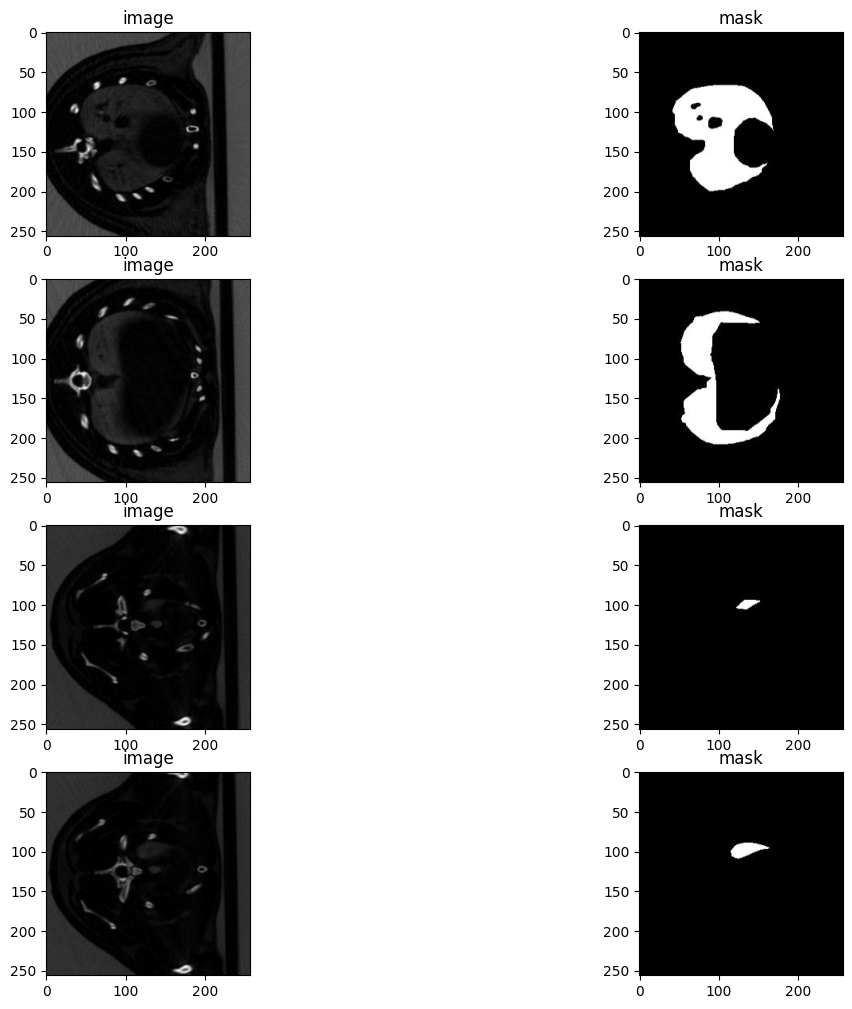

In [165]:
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
fig, axs = plt.subplots(ncols=2, nrows=4, figsize=(12, 10))
plt.tight_layout(pad=1, h_pad=1, w_pad=1)
for i in range(4):
    idx = random.randint(0, 3)
    img = train_features[idx].squeeze()
    label = train_labels[idx].squeeze()
    new_img = np.array([_img for _img in img.numpy()[::-1]])
    new_mask = np.array([_img for _img in label.numpy()[::-1]])
    axs[i, 0].imshow(new_img.T, cmap="gray")
    axs[i, 1].imshow(new_mask.T, cmap="gray")
    axs[i, 0].title.set_text('image')
    axs[i, 1].title.set_text('mask')
plt.show()

# Модель для обучения

In [170]:
# determine the device to be used for training and evaluation
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(DEVICE)
# determine if we will be pinning memory during data loading
PIN_MEMORY = True if DEVICE == "cuda" else False
print(PIN_MEMORY)
# определите количество каналов на входе, количество классов
# и количество уровней в модели U-Net
NUM_CHANNELS = 1
NUM_CLASSES = 1
NUM_LEVELS = 3
# инициализируйте скорость обучения, количество эпох для тренировки и
# размер партии
INIT_LR = 0.001
NUM_EPOCHS = 40
BATCH_SIZE = 64
# определите размеры входного изображения
INPUT_IMAGE_WIDTH = 256 # 128
INPUT_IMAGE_HEIGHT = 256 # 128
# определите порог для фильтрации слабых прогнозов
THRESHOLD = 0.5
# определите путь к базовому выходной директории
BASE_OUTPUT = "Users\1\PycharmProjects\pythonProject2\jpg\нейронка\output"
# определите путь к выходной сериализованной модели, обучающей модели
# построение графика и тестирование путей к изображениям
MODEL_PATH = os.path.join(BASE_OUTPUT, "unet_tgs_salt.pth")
PLOT_PATH = os.path.sep.join([BASE_OUTPUT, "plot.png"])
TEST_PATHS = os.path.sep.join([BASE_OUTPUT, "test_paths.txt"])

cpu
False


блоки

In [167]:
class Block(Module):
	def __init__(self, inChannels, outChannels):
		super().__init__()
		# store the convolution and RELU layers
		self.conv1 = Conv2d(inChannels, outChannels, 3)
		self.relu = ReLU()
		self.conv2 = Conv2d(outChannels, outChannels, 3)
	def forward(self, x):
		# apply CONV => RELU => CONV block to the inputs and return it
		return self.conv2(self.relu(self.conv1(x)))

энкодер

In [204]:
class Encoder(Module):
	def __init__(self, channels=(3, 16, 32, 64)):
		super().__init__()
		# store the encoder blocks and maxpooling layer
		self.encBlocks = ModuleList(
			[Block(channels[i], channels[i + 1])
			 	for i in range(len(channels) - 1)])
		self.pool = MaxPool2d(2)

	def forward(self, x):
		# initialize an empty list to store the intermediate outputs
		blockOutputs = []
		# loop through the encoder blocks
		for block in self.encBlocks:
			# pass the inputs through the current encoder block, store
			# the outputs, and then apply maxpooling on the output
			x = block(x)
			blockOutputs.append(x)
			x = self.pool(x)
		# return the list containing the intermediate outputs
		return blockOutputs

проверяем

Декодер

In [205]:
class Decoder(Module):
	def __init__(self, channels=(64, 32, 16)):
		super().__init__()
		# initialize the number of channels, upsampler blocks, and
		# decoder blocks
		self.channels = channels
		self.upconvs = ModuleList(
			[ConvTranspose2d(channels[i], channels[i + 1], 2, 2)
			 	for i in range(len(channels) - 1)])
		self.dec_blocks = ModuleList(
			[Block(channels[i], channels[i + 1])
			 	for i in range(len(channels) - 1)])
	def forward(self, x, encFeatures):
		# loop through the number of channels
		for i in range(len(self.channels) - 1):
			# pass the inputs through the upsampler blocks
			x = self.upconvs[i](x)
			# crop the current features from the encoder blocks,
			# concatenate them with the current upsampled features,
			# and pass the concatenated output through the current
			# decoder block
			encFeat = self.crop(encFeatures[i], x)
			x = torch.cat([x, encFeat], dim=1)
			x = self.dec_blocks[i](x)
		# return the final decoder output
		return x
	def crop(self, encFeatures, x):
		# grab the dimensions of the inputs, and crop the encoder
		# features to match the dimensions
		(_, _, H, W) = x.shape
		encFeatures = CenterCrop([H, W])(encFeatures)
		# return the cropped features
		return encFeatures

юнет

In [206]:
class UNet(Module):
	def __init__(self, encChannels=(3, 16, 32, 64),
		 decChannels=(64, 32, 16),
		 nbClasses=1, retainDim=True,
		 outSize=(INPUT_IMAGE_HEIGHT,  INPUT_IMAGE_WIDTH)):
		super().__init__()
		# initialize the encoder and decoder
		self.encoder = Encoder(encChannels)
		self.decoder = Decoder(decChannels)
		# initialize the regression head and store the class variables
		self.head = Conv2d(decChannels[-1], nbClasses, 1)
		self.retainDim = retainDim
		self.outSize = outSize

	def forward(self, x):
		# grab the features from the encoder
		encFeatures = self.encoder(x)
		# pass the encoder features through decoder making sure that
		# their dimensions are suited for concatenation
		decFeatures = self.decoder(encFeatures[::-1][0],
			encFeatures[::-1][1:])
		# pass the decoder features through the regression head to
		# obtain the segmentation mask
		map = self.head(decFeatures)
		# check to see if we are retaining the original output
		# dimensions and if so, then resize the output to match them
		if self.retainDim:
			map = F.interpolate(map, self.outSize)
		# return the segmentation map
		return map

трэйн

проверка

In [207]:
# initialize our UNet model
unet = UNet().to(DEVICE)

# initialize loss function and optimizer
lossFunc = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(unet.parameters(), lr=lr)

# calculate steps per epoch for training and test set
trainSteps = len(train_set) // batch_size
testSteps = len(valid_set) // batch_size

# initialize a dictionary to store training history
H = {"train_loss": [], "test_loss": []}

In [208]:
dataloaders = {}
dataloaders['train'] = train_dataloader
dataloaders['val'] = valid_dataloader
dataset_sizes = {}
dataset_sizes['train'] = len(train_set)
dataset_sizes['val'] = len(valid_set)

In [209]:
# import time
import copy

def train_model(model, dataloaders, dataset_sizes, optimizer, criterion, num_epochs=20, scheduler=None):

	# startTime = time.time()

	train_loss = []
	val_loss = []

	best_model_wts = copy.deepcopy(model.state_dict())
	best_loss = 1000.0

	for epoch in range(num_epochs):
		print('Epoch {}/{}'.format(epoch+1, num_epochs))
		print('-' * 10)

		for phase in ['train', 'val']:
			if phase == 'train':
				model.train()
			else:
				model.eval()

			total_loss = 0
			# loop over the training set
			for i, (x, y) in enumerate(dataloaders[phase]):
				print(i)

				# send the input to the device
				(x, y) = (x.to(DEVICE), y.to(DEVICE))

				optimizer.zero_grad()

				# perform a forward pass and calculate the training loss

				with torch.set_grad_enabled(phase == 'train'):
					prediction = model(x)
					loss = criterion(prediction, y)

					if phase == 'train':
						loss.backward()
						optimizer.step()

				# add the loss to the total training loss so far
				total_loss += loss

			if phase == 'train':
				train_loss.append(total_loss / dataset_sizes[phase])
			else:
				val_loss.append(total_loss / dataset_sizes[phase])
				if best_loss < total_loss / dataset_sizes[phase]:
					best_loss = total_loss / dataset_sizes[phase]
					best_model_wts = copy.deepcopy(model.state_dict())

	return {'train_loss': train_loss,'val_loss': val_loss,'best_model': best_model_wts}

# Обучаем

In [ ]:
history = train_model(model = unet,
                      dataloaders = dataloaders,
                      dataset_sizes = dataset_sizes,
                      optimizer = optimizer,
                      criterion = lossFunc,
                      num_epochs = 3)

In [ ]:
# plot the training loss
plt.style.use("ggplot")
plt.figure()
plt.plot(H["train_loss"], label="train_loss")
plt.plot(H["test_loss"], label="test_loss")
plt.title("Training Loss on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="lower left")
plt.savefig(config.PLOT_PATH)
# serialize the model to disk
torch.save(unet, config.MODEL_PATH)

In [ ]:
# USAGE
# python predict.py
# import the necessary packages
from pyimagesearch import config
import matplotlib.pyplot as plt
import numpy as np
import torch
import cv2
import os
def prepare_plot(origImage, origMask, predMask):
	# initialize our figure
	figure, ax = plt.subplots(nrows=1, ncols=3, figsize=(10, 10))
	# plot the original image, its mask, and the predicted mask
	ax[0].imshow(origImage)
	ax[1].imshow(origMask)
	ax[2].imshow(predMask)
	# set the titles of the subplots
	ax[0].set_title("Image")
	ax[1].set_title("Original Mask")
	ax[2].set_title("Predicted Mask")
	# set the layout of the figure and display it
	figure.tight_layout()
	figure.show()

In [ ]:
def make_predictions(model, imagePath):
	# set model to evaluation mode
	model.eval()
	# turn off gradient tracking
	with torch.no_grad():
		# load the image from disk, swap its color channels, cast it
		# to float data type, and scale its pixel values
		image = cv2.imread(imagePath)
		image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
		image = image.astype("float32") / 255.0
		# resize the image and make a copy of it for visualization
		image = cv2.resize(image, (128, 128))
		orig = image.copy()
		# find the filename and generate the path to ground truth
		# mask
		filename = imagePath.split(os.path.sep)[-1]
		groundTruthPath = os.path.join(config.MASK_DATASET_PATH,
			filename)
		# load the ground-truth segmentation mask in grayscale mode
		# and resize it
		gtMask = cv2.imread(groundTruthPath, 0)
		gtMask = cv2.resize(gtMask, (config.INPUT_IMAGE_HEIGHT,
			config.INPUT_IMAGE_HEIGHT))

In [ ]:
# make the channel axis to be the leading one, add a batch
		# dimension, create a PyTorch tensor, and flash it to the
		# current device
		image = np.transpose(image, (2, 0, 1))
		image = np.expand_dims(image, 0)
		image = torch.from_numpy(image).to(config.DEVICE)
		# make the prediction, pass the results through the sigmoid
		# function, and convert the result to a NumPy array
		predMask = model(image).squeeze()
		predMask = torch.sigmoid(predMask)
		predMask = predMask.cpu().numpy()
		# filter out the weak predictions and convert them to integers
		predMask = (predMask > config.THRESHOLD) * 255
		predMask = predMask.astype(np.uint8)
		# prepare a plot for visualization
		prepare_plot(orig, gtMask, predMask)

In [ ]:
# load the image paths in our testing file and randomly select 10
# image paths
print("[INFO] loading up test image paths...")
imagePaths = open(config.TEST_PATHS).read().strip().split("\n")
imagePaths = np.random.choice(imagePaths, size=10)
# load our model from disk and flash it to the current device
print("[INFO] load up model...")
unet = torch.load(config.MODEL_PATH).to(config.DEVICE)
# iterate over the randomly selected test image paths
for path in imagePaths:
	# make predictions and visualize the results
	make_predictions(unet, path)